In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
np.random.seed(0)

In [2]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
from keras.callbacks import History 
#using tensorflow backend

Using TensorFlow backend.


In [3]:
def mse_custom(y_true,y_predicted):
    mse_mod = tf.math.reduce_mean(tf.math.abs(tf.subtract(y_true[3:-3],y_predicted[3:-3])))
    return mse_mod

In [4]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [5]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [6]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [7]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [8]:
def sum_last14(casos_por_dia):
    ac_por_dia = np.copy(casos_por_dia)
    for i in casos_por_dia[:,0]:
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i,1] = np.sum(index) 
    return ac_por_dia

In [9]:
def predict_cases(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the predictions and cases per day
    predicts cases per day after calculating the risk diagram, using the empirical reproductive
    ratio given by rep_fun
    """
    prox_dia = max(fecha_sintomas)+1
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    r_def,a_t = risk_diagram(fecha_sintomas,pop,a,rep_fun,ret=True)
    r_def = r_def[13:]
    a_t = a_t[13:]
    p_t = r_def * a_t
    valid_days = np.arange(19,prox_dia+6,1)
    casos_por_dia = sum_last14(casos_por_dia) #gets all active cases in the last 14-days 
    if graph == True:
        plt.style.use('ggplot')
        plt.xlabel('Dias desde el comienzo')
        plt.ylabel('Infectados activos en BRC')
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1]*(100000/pop),'-ob',markersize=4,label="casos hasta dia: "+str(prox_dia))
        plt.plot(valid_days,p_t,linewidth=3,label='prediccion')
        plt.legend()
        #plt.savefig('9oct_predic_casos.pdf')
    if ret == True:
        error_global = np.linalg.norm(casos_por_dia[19:,1]-p_t[:-6])
        return error_global

In [10]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)
    filt_df2 = (df.fecha_inicio_sintomas < 0)
    df[filt_df2] = 0

In [11]:
data = pd.read_csv("casos/CasosCovid19_arg.txt",sep=",",quotechar='"',
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
df = pd.DataFrame(data) #converting to dataframe for use

In [12]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
ultima_actualizacion_apertura = max(df["fecha_apertura"])
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2020-12-29 00:00:00
ultima apertura de persona confirmada:  2020-12-29 00:00:00


In [13]:
fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
fecha_sintomas = fecha_sintomas.astype(int)

In [14]:
aw = np.zeros(6) + 1
pop = 100000
rep_fun = repratio_t_conv
r_def,a_t = risk_diagram(fecha_sintomas,pop,aw,rep_fun,ret=True) #hasta aca perfecto
a_t = a_t[10:] 
a = a_t[:-4]

In [15]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
casos_por_dia = sum_last14(casos_por_dia)
casos_por_dia = casos_por_dia[17:,1]
b = np.zeros(casos_por_dia.shape[0]+3,dtype=float)
b[:casos_por_dia.shape[0]] = casos_por_dia

In [16]:
casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
n_t = np.copy(casos_por_dia)
prox_dia = max(fecha_sintomas) + 1
#completing the values for the rest of the values of n_t
aux = np.zeros(2)
i = 0
while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
    aux[0] = prox_dia + i
    aux[1] = np.mean(n_t[prox_dia-7:,1])
    n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
    i= i +1
dias = np.copy(n_t[:,0]).astype(int)
dias = dias[dias>=10]
dias = dias[dias<=max(fecha_sintomas)-4]
m1 = np.zeros((dias.shape[0],3)) #denominator of r7 expression
m2 = np.zeros((dias.shape[0],3)) #numerator of r7 expression

In [17]:
for i in dias:
    m1[i-10,:] = n_t[i-6:i-3,1]
    m2[i-10,:] = n_t[i-1:i+2,1]

In [18]:
n_dias = m1.shape[0]

In [19]:
def my_matrix(shape):
    m = np.zeros((shape,shape))
    i = 3
    while i < shape-3:
        m[i,i-3:i+4] = 1/7
        i = i + 1
    return m

In [20]:
def ret_matrix(shape):
    numpyA = my_matrix(shape)
    numpyA = keras.backend.variable(numpyA)
    mat = numpyA
    return mat

In [21]:
n_dias = m1.shape[0]

In [22]:
m1 += np.random.normal(0,25,m1.shape)
m2 += np.random.normal(0,25,m2.shape)

In [23]:
m1.shape == m2.shape

True

In [24]:
mat = ret_matrix(n_dias)

In [25]:
pop = 45376763 #poblacion en cuestion

In [ ]:
input_1 = keras.layers.Input(shape=(3,))
input_2 = keras.layers.Input(shape=(3,))
input_3 = keras.layers.Input(shape=(1,))
initializer = keras.initializers.Ones() #the vector of weights a
l_input_1 = keras.layers.Dense(1,activation='relu',kernel_initializer=initializer,use_bias=False)(input_1)
l_input_2 = keras.layers.Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer,trainable=False)(input_2)
division = keras.layers.Lambda(lambda inputs:  tf.where(inputs[0] != 0, tf.math.minimum(inputs[1]/inputs[0],4), inputs[1]))([l_input_1, l_input_2])#calculates empirical rt
mean = keras.layers.Lambda(lambda x: keras.backend.dot(mat,x))(division) #calculates mean r_seven in seven days
cases = keras.layers.Multiply()([input_3,mean]) #cases for valid prediction,net output, padded with zeros at the end
model = keras.Model(inputs=[input_1,input_2,input_3],outputs=[cases])
optimizer = keras.optimizers.Adam(5e-3)
model.compile(optimizer, loss=mse_custom)
history = model.fit([m1,m2,a*(100000/pop)], b*(100000/pop), epochs=30000, batch_size=n_dias,shuffle=False)
model.summary()

Epoch 1/30000
350/350 [==============================] - 0s 89us/step - loss: 4.9027
Epoch 2/30000
350/350 [==============================] - 0s 44us/step - loss: 5.2967
Epoch 3/30000
350/350 [==============================] - 0s 9us/step - loss: 20.0865
Epoch 4/30000
350/350 [==============================] - 0s 9us/step - loss: 33.2480
Epoch 5/30000
350/350 [==============================] - 0s 9us/step - loss: 49.7811
Epoch 6/30000
350/350 [==============================] - 0s 9us/step - loss: 35.8013
Epoch 7/30000
350/350 [==============================] - 0s 6us/step - loss: 9.4868
Epoch 8/30000
350/350 [==============================] - 0s 9us/step - loss: 55.4945
Epoch 9/30000
350/350 [==============================] - 0s 9us/step - loss: 55.6833
Epoch 10/30000
350/350 [==============================] - 0s 11us/step - loss: 45.2324
Epoch 11/30000
350/350 [==============================] - 0s 6us/step - loss: 27.8816
Epoch 12/30000
350/350 [==============================] - 0s 6u

Epoch 97/30000
350/350 [==============================] - 0s 6us/step - loss: 31.9989
Epoch 98/30000
350/350 [==============================] - 0s 6us/step - loss: 4.8487
Epoch 99/30000
350/350 [==============================] - 0s 9us/step - loss: 4.8733
Epoch 100/30000
350/350 [==============================] - 0s 6us/step - loss: 6.3405
Epoch 101/30000
350/350 [==============================] - 0s 9us/step - loss: 47.1279
Epoch 102/30000
350/350 [==============================] - 0s 9us/step - loss: 53.2694
Epoch 103/30000
350/350 [==============================] - 0s 9us/step - loss: 41.4790
Epoch 104/30000
350/350 [==============================] - 0s 6us/step - loss: 20.8341
Epoch 105/30000
350/350 [==============================] - 0s 6us/step - loss: 30.8012
Epoch 106/30000
350/350 [==============================] - 0s 11us/step - loss: 49.2568
Epoch 107/30000
350/350 [==============================] - 0s 9us/step - loss: 34.9195
Epoch 108/30000
350/350 [=======================

Epoch 192/30000
350/350 [==============================] - 0s 9us/step - loss: 4.8033
Epoch 193/30000
350/350 [==============================] - 0s 6us/step - loss: 6.7837
Epoch 194/30000
350/350 [==============================] - 0s 9us/step - loss: 48.9991
Epoch 195/30000
350/350 [==============================] - 0s 9us/step - loss: 53.7982
Epoch 196/30000
350/350 [==============================] - 0s 9us/step - loss: 42.2829
Epoch 197/30000
350/350 [==============================] - 0s 9us/step - loss: 22.4134
Epoch 198/30000
350/350 [==============================] - 0s 6us/step - loss: 25.6965
Epoch 199/30000
350/350 [==============================] - 0s 9us/step - loss: 48.2730
Epoch 200/30000
350/350 [==============================] - 0s 9us/step - loss: 33.2140
Epoch 201/30000
350/350 [==============================] - 0s 9us/step - loss: 5.3841
Epoch 202/30000
350/350 [==============================] - 0s 9us/step - loss: 34.8737
Epoch 203/30000
350/350 [=====================

Epoch 287/30000
350/350 [==============================] - 0s 6us/step - loss: 24.2920
Epoch 288/30000
350/350 [==============================] - 0s 6us/step - loss: 47.9785
Epoch 289/30000
350/350 [==============================] - 0s 6us/step - loss: 32.7583
Epoch 290/30000
350/350 [==============================] - 0s 9us/step - loss: 4.9468
Epoch 291/30000
350/350 [==============================] - 0s 9us/step - loss: 19.9333
Epoch 292/30000
350/350 [==============================] - 0s 6us/step - loss: 47.2463
Epoch 293/30000
350/350 [==============================] - 0s 9us/step - loss: 31.4873
Epoch 294/30000
350/350 [==============================] - 0s 6us/step - loss: 4.7840
Epoch 295/30000
350/350 [==============================] - 0s 6us/step - loss: 8.6726
Epoch 296/30000
350/350 [==============================] - 0s 9us/step - loss: 57.3658
Epoch 297/30000
350/350 [==============================] - 0s 9us/step - loss: 56.2343
Epoch 298/30000
350/350 [=====================

Epoch 382/30000
350/350 [==============================] - 0s 9us/step - loss: 46.1606
Epoch 383/30000
350/350 [==============================] - 0s 6us/step - loss: 29.5723
Epoch 384/30000
350/350 [==============================] - 0s 6us/step - loss: 6.9377
Epoch 385/30000
350/350 [==============================] - 0s 8us/step - loss: 35.2890
Epoch 386/30000
350/350 [==============================] - 0s 6us/step - loss: 8.5398
Epoch 387/30000
350/350 [==============================] - 0s 6us/step - loss: 55.4311
Epoch 388/30000
350/350 [==============================] - 0s 6us/step - loss: 55.6499
Epoch 389/30000
350/350 [==============================] - 0s 6us/step - loss: 45.1964
Epoch 390/30000
350/350 [==============================] - 0s 6us/step - loss: 27.8400
Epoch 391/30000
350/350 [==============================] - 0s 6us/step - loss: 10.5524
Epoch 392/30000
350/350 [==============================] - 0s 6us/step - loss: 41.7095
Epoch 393/30000
350/350 [====================

Epoch 477/30000
350/350 [==============================] - 0s 9us/step - loss: 20.8217
Epoch 478/30000
350/350 [==============================] - 0s 6us/step - loss: 47.3945
Epoch 479/30000
350/350 [==============================] - 0s 6us/step - loss: 31.7460
Epoch 480/30000
350/350 [==============================] - 0s 6us/step - loss: 4.6849
Epoch 481/30000
350/350 [==============================] - 0s 6us/step - loss: 5.4599
Epoch 482/30000
350/350 [==============================] - 0s 9us/step - loss: 37.6326
Epoch 483/30000
350/350 [==============================] - 0s 9us/step - loss: 50.7776
Epoch 484/30000
350/350 [==============================] - 0s 9us/step - loss: 37.4744
Epoch 485/30000
350/350 [==============================] - 0s 6us/step - loss: 12.8066
Epoch 486/30000
350/350 [==============================] - 0s 9us/step - loss: 55.7051
Epoch 487/30000
350/350 [==============================] - 0s 9us/step - loss: 55.7368
Epoch 488/30000
350/350 [====================

Epoch 572/30000
350/350 [==============================] - 0s 9us/step - loss: 11.9116
Epoch 573/30000
350/350 [==============================] - 0s 6us/step - loss: 56.9760
Epoch 574/30000
350/350 [==============================] - 0s 9us/step - loss: 56.1200
Epoch 575/30000
350/350 [==============================] - 0s 6us/step - loss: 45.9117
Epoch 576/30000
350/350 [==============================] - 0s 9us/step - loss: 29.1299
Epoch 577/30000
350/350 [==============================] - 0s 6us/step - loss: 7.7471
Epoch 578/30000
350/350 [==============================] - 0s 9us/step - loss: 37.9140
Epoch 579/30000
350/350 [==============================] - 0s 6us/step - loss: 13.6985
Epoch 580/30000
350/350 [==============================] - 0s 6us/step - loss: 53.7390
Epoch 581/30000
350/350 [==============================] - 0s 9us/step - loss: 55.1504
Epoch 582/30000
350/350 [==============================] - 0s 6us/step - loss: 44.4306
Epoch 583/30000
350/350 [===================

Epoch 667/30000
350/350 [==============================] - 0s 6us/step - loss: 34.9239
Epoch 668/30000
350/350 [==============================] - 0s 6us/step - loss: 50.1431
Epoch 669/30000
350/350 [==============================] - 0s 9us/step - loss: 36.4263
Epoch 670/30000
350/350 [==============================] - 0s 6us/step - loss: 10.7126
Epoch 671/30000
350/350 [==============================] - 0s 9us/step - loss: 60.3130
Epoch 672/30000
350/350 [==============================] - 0s 6us/step - loss: 57.1489
Epoch 673/30000
350/350 [==============================] - 0s 6us/step - loss: 47.4613
Epoch 674/30000
350/350 [==============================] - 0s 6us/step - loss: 31.8636
Epoch 675/30000
350/350 [==============================] - 0s 6us/step - loss: 4.6269
Epoch 676/30000
350/350 [==============================] - 0s 6us/step - loss: 5.2006
Epoch 677/30000
350/350 [==============================] - 0s 6us/step - loss: 34.9983
Epoch 678/30000
350/350 [====================

Epoch 762/30000
350/350 [==============================] - 0s 9us/step - loss: 5.4443
Epoch 763/30000
350/350 [==============================] - 0s 6us/step - loss: 27.0249
Epoch 764/30000
350/350 [==============================] - 0s 9us/step - loss: 12.5399
Epoch 765/30000
350/350 [==============================] - 0s 9us/step - loss: 44.2616
Epoch 766/30000
350/350 [==============================] - 0s 6us/step - loss: 26.1315
Epoch 767/30000
350/350 [==============================] - 0s 9us/step - loss: 14.8972
Epoch 768/30000
350/350 [==============================] - 0s 9us/step - loss: 45.7195
Epoch 769/30000
350/350 [==============================] - 0s 6us/step - loss: 28.7843
Epoch 770/30000
350/350 [==============================] - 0s 9us/step - loss: 8.4384
Epoch 771/30000
350/350 [==============================] - 0s 11us/step - loss: 38.9982
Epoch 772/30000
350/350 [==============================] - 0s 6us/step - loss: 15.9178
Epoch 773/30000
350/350 [===================

Epoch 857/30000
350/350 [==============================] - 0s 6us/step - loss: 53.1048
Epoch 858/30000
350/350 [==============================] - 0s 9us/step - loss: 54.9685
Epoch 859/30000
350/350 [==============================] - 0s 9us/step - loss: 44.1519
Epoch 860/30000
350/350 [==============================] - 0s 11us/step - loss: 25.9282
Epoch 861/30000
350/350 [==============================] - 0s 6us/step - loss: 15.4490
Epoch 862/30000
350/350 [==============================] - 0s 6us/step - loss: 45.8312
Epoch 863/30000
350/350 [==============================] - 0s 9us/step - loss: 28.9838
Epoch 864/30000
350/350 [==============================] - 0s 9us/step - loss: 8.0182
Epoch 865/30000
350/350 [==============================] - 0s 6us/step - loss: 38.1021
Epoch 866/30000
350/350 [==============================] - 0s 11us/step - loss: 14.0811
Epoch 867/30000
350/350 [==============================] - 0s 9us/step - loss: 53.8661
Epoch 868/30000
350/350 [=================

Epoch 952/30000
350/350 [==============================] - 0s 6us/step - loss: 12.0601
Epoch 953/30000
350/350 [==============================] - 0s 6us/step - loss: 56.5033
Epoch 954/30000
350/350 [==============================] - 0s 9us/step - loss: 55.9456
Epoch 955/30000
350/350 [==============================] - 0s 6us/step - loss: 45.6481
Epoch 956/30000
350/350 [==============================] - 0s 9us/step - loss: 28.6547
Epoch 957/30000
350/350 [==============================] - 0s 9us/step - loss: 8.6977
Epoch 958/30000
350/350 [==============================] - 0s 9us/step - loss: 39.0485
Epoch 959/30000
350/350 [==============================] - 0s 9us/step - loss: 16.0183
Epoch 960/30000
350/350 [==============================] - 0s 6us/step - loss: 47.1133
Epoch 961/30000
350/350 [==============================] - 0s 6us/step - loss: 53.2160
Epoch 962/30000
350/350 [==============================] - 0s 11us/step - loss: 41.4121
Epoch 963/30000
350/350 [==================

Epoch 1046/30000
350/350 [==============================] - 0s 6us/step - loss: 54.9837
Epoch 1047/30000
350/350 [==============================] - 0s 6us/step - loss: 44.1749
Epoch 1048/30000
350/350 [==============================] - 0s 9us/step - loss: 25.9698
Epoch 1049/30000
350/350 [==============================] - 0s 6us/step - loss: 15.3448
Epoch 1050/30000
350/350 [==============================] - 0s 6us/step - loss: 45.8223
Epoch 1051/30000
350/350 [==============================] - 0s 6us/step - loss: 28.9670
Epoch 1052/30000
350/350 [==============================] - 0s 9us/step - loss: 8.0439
Epoch 1053/30000
350/350 [==============================] - 0s 9us/step - loss: 38.1925
Epoch 1054/30000
350/350 [==============================] - 0s 6us/step - loss: 14.2663
Epoch 1055/30000
350/350 [==============================] - 0s 6us/step - loss: 53.2857
Epoch 1056/30000
350/350 [==============================] - 0s 6us/step - loss: 54.9847
Epoch 1057/30000
350/350 [=======

Epoch 1140/30000
350/350 [==============================] - 0s 9us/step - loss: 63.8478
Epoch 1141/30000
350/350 [==============================] - 0s 9us/step - loss: 58.2274
Epoch 1142/30000
350/350 [==============================] - 0s 9us/step - loss: 49.0627
Epoch 1143/30000
350/350 [==============================] - 0s 6us/step - loss: 34.6110
Epoch 1144/30000
350/350 [==============================] - 0s 9us/step - loss: 7.3091
Epoch 1145/30000
350/350 [==============================] - 0s 6us/step - loss: 53.2547
Epoch 1146/30000
350/350 [==============================] - 0s 9us/step - loss: 54.9774
Epoch 1147/30000
350/350 [==============================] - 0s 6us/step - loss: 44.1649
Epoch 1148/30000
350/350 [==============================] - 0s 6us/step - loss: 25.9511
Epoch 1149/30000
350/350 [==============================] - 0s 8us/step - loss: 15.3958
Epoch 1150/30000
350/350 [==============================] - 0s 6us/step - loss: 45.8261
Epoch 1151/30000
350/350 [=======

Epoch 1234/30000
350/350 [==============================] - 0s 9us/step - loss: 41.4228
Epoch 1235/30000
350/350 [==============================] - 0s 9us/step - loss: 20.7504
Epoch 1236/30000
350/350 [==============================] - 0s 6us/step - loss: 31.1369
Epoch 1237/30000
350/350 [==============================] - 0s 6us/step - loss: 49.2918
Epoch 1238/30000
350/350 [==============================] - 0s 8us/step - loss: 34.9979
Epoch 1239/30000
350/350 [==============================] - 0s 6us/step - loss: 7.9697
Epoch 1240/30000
350/350 [==============================] - 0s 9us/step - loss: 56.9489
Epoch 1241/30000
350/350 [==============================] - 0s 6us/step - loss: 56.0862
Epoch 1242/30000
350/350 [==============================] - 0s 6us/step - loss: 45.8614
Epoch 1243/30000
350/350 [==============================] - 0s 11us/step - loss: 29.0364
Epoch 1244/30000
350/350 [==============================] - 0s 6us/step - loss: 7.9075
Epoch 1245/30000
350/350 [=======

Epoch 1328/30000
350/350 [==============================] - 0s 6us/step - loss: 47.7197
Epoch 1329/30000
350/350 [==============================] - 0s 9us/step - loss: 32.3097
Epoch 1330/30000
350/350 [==============================] - 0s 9us/step - loss: 4.5615
Epoch 1331/30000
350/350 [==============================] - 0s 9us/step - loss: 6.2023
Epoch 1332/30000
350/350 [==============================] - 0s 9us/step - loss: 31.8915
Epoch 1333/30000
350/350 [==============================] - 0s 6us/step - loss: 4.5296
Epoch 1334/30000
350/350 [==============================] - 0s 9us/step - loss: 5.0622
Epoch 1335/30000
350/350 [==============================] - 0s 9us/step - loss: 35.7476
Epoch 1336/30000
350/350 [==============================] - 0s 6us/step - loss: 50.3142
Epoch 1337/30000
350/350 [==============================] - 0s 11us/step - loss: 36.7077
Epoch 1338/30000
350/350 [==============================] - 0s 9us/step - loss: 11.2629
Epoch 1339/30000
350/350 [=========

Epoch 1422/30000
350/350 [==============================] - 0s 6us/step - loss: 56.1636
Epoch 1423/30000
350/350 [==============================] - 0s 8us/step - loss: 45.9781
Epoch 1424/30000
350/350 [==============================] - 0s 6us/step - loss: 29.2449
Epoch 1425/30000
350/350 [==============================] - 0s 9us/step - loss: 7.4846
Epoch 1426/30000
350/350 [==============================] - 0s 9us/step - loss: 37.5873
Epoch 1427/30000
350/350 [==============================] - 0s 6us/step - loss: 13.0344
Epoch 1428/30000
350/350 [==============================] - 0s 8us/step - loss: 54.9400
Epoch 1429/30000
350/350 [==============================] - 0s 6us/step - loss: 55.4865
Epoch 1430/30000
350/350 [==============================] - 0s 6us/step - loss: 44.9464
Epoch 1431/30000
350/350 [==============================] - 0s 6us/step - loss: 27.3838
Epoch 1432/30000
350/350 [==============================] - 0s 6us/step - loss: 11.6331
Epoch 1433/30000
350/350 [=======

Epoch 1516/30000
350/350 [==============================] - 0s 9us/step - loss: 5.7014
Epoch 1517/30000
350/350 [==============================] - 0s 6us/step - loss: 50.1324
Epoch 1518/30000
350/350 [==============================] - 0s 6us/step - loss: 54.0790
Epoch 1519/30000
350/350 [==============================] - 0s 6us/step - loss: 42.7686
Epoch 1520/30000
350/350 [==============================] - 0s 6us/step - loss: 23.3380
Epoch 1521/30000
350/350 [==============================] - 0s 9us/step - loss: 23.0678
Epoch 1522/30000
350/350 [==============================] - 0s 6us/step - loss: 47.7712
Epoch 1523/30000
350/350 [==============================] - 0s 8us/step - loss: 32.3988
Epoch 1524/30000
350/350 [==============================] - 0s 8us/step - loss: 4.5550
Epoch 1525/30000
350/350 [==============================] - 0s 8us/step - loss: 7.7946
Epoch 1526/30000
350/350 [==============================] - 0s 6us/step - loss: 37.9842
Epoch 1527/30000
350/350 [=========

350/350 [==============================] - 0s 6us/step - loss: 17.3686
Epoch 1610/30000
350/350 [==============================] - 0s 8us/step - loss: 46.5818
Epoch 1611/30000
350/350 [==============================] - 0s 6us/step - loss: 30.3195
Epoch 1612/30000
350/350 [==============================] - 0s 9us/step - loss: 5.8171
Epoch 1613/30000
350/350 [==============================] - 0s 6us/step - loss: 29.7146
Epoch 1614/30000
350/350 [==============================] - 0s 6us/step - loss: 6.7553
Epoch 1615/30000
350/350 [==============================] - 0s 11us/step - loss: 32.9991
Epoch 1616/30000
350/350 [==============================] - 0s 9us/step - loss: 4.9409
Epoch 1617/30000
350/350 [==============================] - 0s 6us/step - loss: 33.7509
Epoch 1618/30000
350/350 [==============================] - 0s 6us/step - loss: 49.8651
Epoch 1619/30000
350/350 [==============================] - 0s 8us/step - loss: 35.9598
Epoch 1620/30000
350/350 [=========================

Epoch 1703/30000
350/350 [==============================] - 0s 8us/step - loss: 31.5666
Epoch 1704/30000
350/350 [==============================] - 0s 6us/step - loss: 4.6998
Epoch 1705/30000
350/350 [==============================] - 0s 6us/step - loss: 8.2986
Epoch 1706/30000
350/350 [==============================] - 0s 8us/step - loss: 59.5431
Epoch 1707/30000
350/350 [==============================] - 0s 6us/step - loss: 56.8961
Epoch 1708/30000
350/350 [==============================] - 0s 9us/step - loss: 47.0825
Epoch 1709/30000
350/350 [==============================] - 0s 9us/step - loss: 31.1997
Epoch 1710/30000
350/350 [==============================] - 0s 6us/step - loss: 4.8718
Epoch 1711/30000
350/350 [==============================] - 0s 9us/step - loss: 14.4919
Epoch 1712/30000
350/350 [==============================] - 0s 6us/step - loss: 52.4144
Epoch 1713/30000
350/350 [==============================] - 0s 9us/step - loss: 54.7471
Epoch 1714/30000
350/350 [=========

Epoch 1797/30000
350/350 [==============================] - 0s 3us/step - loss: 32.5177
Epoch 1798/30000
350/350 [==============================] - 0s 6us/step - loss: 49.5999
Epoch 1799/30000
350/350 [==============================] - 0s 6us/step - loss: 35.5162
Epoch 1800/30000
350/350 [==============================] - 0s 6us/step - loss: 9.0497
Epoch 1801/30000
350/350 [==============================] - 0s 9us/step - loss: 64.7981
Epoch 1802/30000
350/350 [==============================] - 0s 6us/step - loss: 58.5513
Epoch 1803/30000
350/350 [==============================] - 0s 8us/step - loss: 49.5373
Epoch 1804/30000
350/350 [==============================] - 0s 6us/step - loss: 35.4110
Epoch 1805/30000
350/350 [==============================] - 0s 6us/step - loss: 8.8484
Epoch 1806/30000
350/350 [==============================] - 0s 6us/step - loss: 60.6981
Epoch 1807/30000
350/350 [==============================] - 0s 6us/step - loss: 57.2584
Epoch 1808/30000
350/350 [========

Epoch 1891/30000
350/350 [==============================] - 0s 9us/step - loss: 54.6376
Epoch 1892/30000
350/350 [==============================] - 0s 11us/step - loss: 43.6386
Epoch 1893/30000
350/350 [==============================] - 0s 6us/step - loss: 24.9816
Epoch 1894/30000
350/350 [==============================] - 0s 9us/step - loss: 18.2888
Epoch 1895/30000
350/350 [==============================] - 0s 6us/step - loss: 46.7857
Epoch 1896/30000
350/350 [==============================] - 0s 6us/step - loss: 30.6866
Epoch 1897/30000
350/350 [==============================] - 0s 9us/step - loss: 5.3190
Epoch 1898/30000
350/350 [==============================] - 0s 6us/step - loss: 25.2245
Epoch 1899/30000
350/350 [==============================] - 0s 6us/step - loss: 17.5999
Epoch 1900/30000
350/350 [==============================] - 0s 6us/step - loss: 46.6991
Epoch 1901/30000
350/350 [==============================] - 0s 6us/step - loss: 30.5339
Epoch 1902/30000
350/350 [======

Epoch 1985/30000
350/350 [==============================] - 0s 9us/step - loss: 33.2019
Epoch 1986/30000
350/350 [==============================] - 0s 6us/step - loss: 49.7563
Epoch 1987/30000
350/350 [==============================] - 0s 6us/step - loss: 35.7866
Epoch 1988/30000
350/350 [==============================] - 0s 8us/step - loss: 9.5590
Epoch 1989/30000
350/350 [==============================] - 0s 6us/step - loss: 64.5292
Epoch 1990/30000
350/350 [==============================] - 0s 11us/step - loss: 58.4757
Epoch 1991/30000
350/350 [==============================] - 0s 9us/step - loss: 49.4270
Epoch 1992/30000
350/350 [==============================] - 0s 9us/step - loss: 35.2339
Epoch 1993/30000
350/350 [==============================] - 0s 9us/step - loss: 8.4935
Epoch 1994/30000
350/350 [==============================] - 0s 6us/step - loss: 59.2756
Epoch 1995/30000
350/350 [==============================] - 0s 6us/step - loss: 56.8267
Epoch 1996/30000
350/350 [=======

Epoch 2079/30000
350/350 [==============================] - 0s 9us/step - loss: 5.0661
Epoch 2080/30000
350/350 [==============================] - 0s 6us/step - loss: 35.1972
Epoch 2081/30000
350/350 [==============================] - 0s 6us/step - loss: 50.2076
Epoch 2082/30000
350/350 [==============================] - 0s 6us/step - loss: 36.5392
Epoch 2083/30000
350/350 [==============================] - 0s 6us/step - loss: 11.0540
Epoch 2084/30000
350/350 [==============================] - 0s 8us/step - loss: 59.7420
Epoch 2085/30000
350/350 [==============================] - 0s 9us/step - loss: 56.9738
Epoch 2086/30000
350/350 [==============================] - 0s 6us/step - loss: 47.1994
Epoch 2087/30000
350/350 [==============================] - 0s 8us/step - loss: 31.4118
Epoch 2088/30000
350/350 [==============================] - 0s 6us/step - loss: 4.7106
Epoch 2089/30000
350/350 [==============================] - 0s 6us/step - loss: 11.5175
Epoch 2090/30000
350/350 [========

Epoch 2173/30000
350/350 [==============================] - 0s 6us/step - loss: 64.4494
Epoch 2174/30000
350/350 [==============================] - 0s 6us/step - loss: 58.4493
Epoch 2175/30000
350/350 [==============================] - 0s 6us/step - loss: 49.3881
Epoch 2176/30000
350/350 [==============================] - 0s 6us/step - loss: 35.1679
Epoch 2177/30000
350/350 [==============================] - 0s 9us/step - loss: 8.3680
Epoch 2178/30000
350/350 [==============================] - 0s 6us/step - loss: 58.7140
Epoch 2179/30000
350/350 [==============================] - 0s 9us/step - loss: 56.6584
Epoch 2180/30000
350/350 [==============================] - 0s 9us/step - loss: 46.7249
Epoch 2181/30000
350/350 [==============================] - 0s 6us/step - loss: 30.5783
Epoch 2182/30000
350/350 [==============================] - 0s 6us/step - loss: 5.4362
Epoch 2183/30000
350/350 [==============================] - 0s 6us/step - loss: 26.5646
Epoch 2184/30000
350/350 [========

Epoch 2267/30000
350/350 [==============================] - 0s 6us/step - loss: 23.4550
Epoch 2268/30000
350/350 [==============================] - 0s 6us/step - loss: 23.1866
Epoch 2269/30000
350/350 [==============================] - 0s 6us/step - loss: 47.8073
Epoch 2270/30000
350/350 [==============================] - 0s 6us/step - loss: 32.4689
Epoch 2271/30000
350/350 [==============================] - 0s 9us/step - loss: 4.6216
Epoch 2272/30000
350/350 [==============================] - 0s 6us/step - loss: 9.3522
Epoch 2273/30000
350/350 [==============================] - 0s 6us/step - loss: 40.0536
Epoch 2274/30000
350/350 [==============================] - 0s 9us/step - loss: 18.1796
Epoch 2275/30000
350/350 [==============================] - 0s 6us/step - loss: 40.3697
Epoch 2276/30000
350/350 [==============================] - 0s 9us/step - loss: 51.4601
Epoch 2277/30000
350/350 [==============================] - 0s 6us/step - loss: 38.5989
Epoch 2278/30000
350/350 [========

Epoch 2361/30000
350/350 [==============================] - 0s 9us/step - loss: 56.6793
Epoch 2362/30000
350/350 [==============================] - 0s 6us/step - loss: 46.7594
Epoch 2363/30000
350/350 [==============================] - 0s 6us/step - loss: 30.6347
Epoch 2364/30000
350/350 [==============================] - 0s 6us/step - loss: 5.3623
Epoch 2365/30000
350/350 [==============================] - 0s 9us/step - loss: 26.4274
Epoch 2366/30000
350/350 [==============================] - 0s 6us/step - loss: 14.6645
Epoch 2367/30000
350/350 [==============================] - 0s 6us/step - loss: 45.7957
Epoch 2368/30000
350/350 [==============================] - 0s 6us/step - loss: 29.0537
Epoch 2369/30000
350/350 [==============================] - 0s 9us/step - loss: 8.2897
Epoch 2370/30000
350/350 [==============================] - 0s 6us/step - loss: 38.6516
Epoch 2371/30000
350/350 [==============================] - 0s 6us/step - loss: 15.3388
Epoch 2372/30000
350/350 [========

Epoch 2455/30000
350/350 [==============================] - 0s 6us/step - loss: 54.1614
Epoch 2456/30000
350/350 [==============================] - 0s 9us/step - loss: 42.9056
Epoch 2457/30000
350/350 [==============================] - 0s 9us/step - loss: 23.7299
Epoch 2458/30000
350/350 [==============================] - 0s 6us/step - loss: 22.3662
Epoch 2459/30000
350/350 [==============================] - 0s 6us/step - loss: 47.6868
Epoch 2460/30000
350/350 [==============================] - 0s 9us/step - loss: 32.2457
Epoch 2461/30000
350/350 [==============================] - 0s 6us/step - loss: 4.5520
Epoch 2462/30000
350/350 [==============================] - 0s 6us/step - loss: 4.9502
Epoch 2463/30000
350/350 [==============================] - 0s 11us/step - loss: 20.4290
Epoch 2464/30000
350/350 [==============================] - 0s 6us/step - loss: 32.7149
Epoch 2465/30000
350/350 [==============================] - 0s 6us/step - loss: 49.6595
Epoch 2466/30000
350/350 [=======

Epoch 2549/30000
350/350 [==============================] - 0s 6us/step - loss: 53.3305
Epoch 2550/30000
350/350 [==============================] - 0s 9us/step - loss: 55.0409
Epoch 2551/30000
350/350 [==============================] - 0s 6us/step - loss: 44.2696
Epoch 2552/30000
350/350 [==============================] - 0s 9us/step - loss: 26.2779
Epoch 2553/30000
350/350 [==============================] - 0s 6us/step - loss: 15.0728
Epoch 2554/30000
350/350 [==============================] - 0s 6us/step - loss: 46.0123
Epoch 2555/30000
350/350 [==============================] - 0s 9us/step - loss: 29.4407
Epoch 2556/30000
350/350 [==============================] - 0s 9us/step - loss: 7.5083
Epoch 2557/30000
350/350 [==============================] - 0s 6us/step - loss: 37.8139
Epoch 2558/30000
350/350 [==============================] - 0s 6us/step - loss: 13.6187
Epoch 2559/30000
350/350 [==============================] - 0s 9us/step - loss: 54.9193
Epoch 2560/30000
350/350 [=======

Epoch 2643/30000
350/350 [==============================] - 0s 6us/step - loss: 6.8094
Epoch 2644/30000
350/350 [==============================] - 0s 11us/step - loss: 51.9978
Epoch 2645/30000
350/350 [==============================] - 0s 6us/step - loss: 54.6521
Epoch 2646/30000
350/350 [==============================] - 0s 9us/step - loss: 43.6685
Epoch 2647/30000
350/350 [==============================] - 0s 6us/step - loss: 25.1624
Epoch 2648/30000
350/350 [==============================] - 0s 6us/step - loss: 18.1874
Epoch 2649/30000
350/350 [==============================] - 0s 6us/step - loss: 46.7925
Epoch 2650/30000
350/350 [==============================] - 0s 6us/step - loss: 30.8242
Epoch 2651/30000
350/350 [==============================] - 0s 6us/step - loss: 5.2933
Epoch 2652/30000
350/350 [==============================] - 0s 6us/step - loss: 25.8094
Epoch 2653/30000
350/350 [==============================] - 0s 6us/step - loss: 16.3649
Epoch 2654/30000
350/350 [=======

Epoch 2737/30000
350/350 [==============================] - 0s 9us/step - loss: 44.9669
Epoch 2738/30000
350/350 [==============================] - 0s 6us/step - loss: 27.5551
Epoch 2739/30000
350/350 [==============================] - 0s 6us/step - loss: 11.7188
Epoch 2740/30000
350/350 [==============================] - 0s 9us/step - loss: 43.5921
Epoch 2741/30000
350/350 [==============================] - 0s 6us/step - loss: 25.0198
Epoch 2742/30000
350/350 [==============================] - 0s 6us/step - loss: 18.5943
Epoch 2743/30000
350/350 [==============================] - 0s 6us/step - loss: 46.8731
Epoch 2744/30000
350/350 [==============================] - 0s 6us/step - loss: 30.9662
Epoch 2745/30000
350/350 [==============================] - 0s 11us/step - loss: 5.1278
Epoch 2746/30000
350/350 [==============================] - 0s 9us/step - loss: 24.3484
Epoch 2747/30000
350/350 [==============================] - 0s 6us/step - loss: 20.5415
Epoch 2748/30000
350/350 [======

Epoch 2831/30000
350/350 [==============================] - 0s 9us/step - loss: 34.8126
Epoch 2832/30000
350/350 [==============================] - 0s 9us/step - loss: 7.4774
Epoch 2833/30000
350/350 [==============================] - 0s 6us/step - loss: 54.9465
Epoch 2834/30000
350/350 [==============================] - 0s 6us/step - loss: 55.5268
Epoch 2835/30000
350/350 [==============================] - 0s 6us/step - loss: 45.0155
Epoch 2836/30000
350/350 [==============================] - 0s 6us/step - loss: 27.6433
Epoch 2837/30000
350/350 [==============================] - 0s 6us/step - loss: 11.4999
Epoch 2838/30000
350/350 [==============================] - 0s 6us/step - loss: 43.5754
Epoch 2839/30000
350/350 [==============================] - 0s 6us/step - loss: 24.9883
Epoch 2840/30000
350/350 [==============================] - 0s 6us/step - loss: 18.6856
Epoch 2841/30000
350/350 [==============================] - 0s 9us/step - loss: 46.8861
Epoch 2842/30000
350/350 [=======

Epoch 2925/30000
350/350 [==============================] - 0s 6us/step - loss: 44.8270
Epoch 2926/30000
350/350 [==============================] - 0s 7us/step - loss: 27.2992
Epoch 2927/30000
350/350 [==============================] - 0s 11us/step - loss: 12.3645
Epoch 2928/30000
350/350 [==============================] - 0s 6us/step - loss: 44.4998
Epoch 2929/30000
350/350 [==============================] - 0s 9us/step - loss: 26.7001
Epoch 2930/30000
350/350 [==============================] - 0s 6us/step - loss: 13.9327
Epoch 2931/30000
350/350 [==============================] - 0s 9us/step - loss: 45.6976
Epoch 2932/30000
350/350 [==============================] - 0s 11us/step - loss: 28.8758
Epoch 2933/30000
350/350 [==============================] - 0s 6us/step - loss: 8.6543
Epoch 2934/30000
350/350 [==============================] - 0s 9us/step - loss: 38.9019
Epoch 2935/30000
350/350 [==============================] - 0s 6us/step - loss: 15.5681
Epoch 2936/30000
350/350 [=====

350/350 [==============================] - 0s 6us/step - loss: 56.9220
Epoch 3019/30000
350/350 [==============================] - 0s 9us/step - loss: 47.1289
Epoch 3020/30000
350/350 [==============================] - 0s 6us/step - loss: 31.4143
Epoch 3021/30000
350/350 [==============================] - 0s 6us/step - loss: 4.7443
Epoch 3022/30000
350/350 [==============================] - 0s 11us/step - loss: 14.8607
Epoch 3023/30000
350/350 [==============================] - 0s 6us/step - loss: 52.2119
Epoch 3024/30000
350/350 [==============================] - 0s 9us/step - loss: 54.7297
Epoch 3025/30000
350/350 [==============================] - 0s 6us/step - loss: 43.7764
Epoch 3026/30000
350/350 [==============================] - 0s 6us/step - loss: 25.3623
Epoch 3027/30000
350/350 [==============================] - 0s 6us/step - loss: 17.6243
Epoch 3028/30000
350/350 [==============================] - 0s 9us/step - loss: 46.7254
Epoch 3029/30000
350/350 [=======================

Epoch 3112/30000
350/350 [==============================] - 0s 6us/step - loss: 54.1384
Epoch 3113/30000
350/350 [==============================] - 0s 9us/step - loss: 42.8564
Epoch 3114/30000
350/350 [==============================] - 0s 6us/step - loss: 23.6344
Epoch 3115/30000
350/350 [==============================] - 0s 9us/step - loss: 22.6630
Epoch 3116/30000
350/350 [==============================] - 0s 6us/step - loss: 47.7421
Epoch 3117/30000
350/350 [==============================] - 0s 6us/step - loss: 32.4821
Epoch 3118/30000
350/350 [==============================] - 0s 9us/step - loss: 4.5386
Epoch 3119/30000
350/350 [==============================] - 0s 9us/step - loss: 7.5349
Epoch 3120/30000
350/350 [==============================] - 0s 6us/step - loss: 37.7253
Epoch 3121/30000
350/350 [==============================] - 0s 6us/step - loss: 13.1562
Epoch 3122/30000
350/350 [==============================] - 0s 9us/step - loss: 55.9850
Epoch 3123/30000
350/350 [========

Epoch 3206/30000
350/350 [==============================] - 0s 8us/step - loss: 8.5303
Epoch 3207/30000
350/350 [==============================] - 0s 6us/step - loss: 62.1716
Epoch 3208/30000
350/350 [==============================] - 0s 6us/step - loss: 57.7475
Epoch 3209/30000
350/350 [==============================] - 0s 6us/step - loss: 48.3599
Epoch 3210/30000
350/350 [==============================] - 0s 6us/step - loss: 33.5471
Epoch 3211/30000
350/350 [==============================] - 0s 11us/step - loss: 5.5064
Epoch 3212/30000
350/350 [==============================] - 0s 9us/step - loss: 46.0598
Epoch 3213/30000
350/350 [==============================] - 0s 6us/step - loss: 52.9830
Epoch 3214/30000
350/350 [==============================] - 0s 6us/step - loss: 41.1762
Epoch 3215/30000
350/350 [==============================] - 0s 6us/step - loss: 20.1317
Epoch 3216/30000
350/350 [==============================] - 0s 9us/step - loss: 33.7210
Epoch 3217/30000
350/350 [=======

Epoch 3300/30000
350/350 [==============================] - 0s 9us/step - loss: 55.9315
Epoch 3301/30000
350/350 [==============================] - 0s 14us/step - loss: 55.8255
Epoch 3302/30000
350/350 [==============================] - 0s 8us/step - loss: 45.4715
Epoch 3303/30000
350/350 [==============================] - 0s 9us/step - loss: 28.4689
Epoch 3304/30000
350/350 [==============================] - 0s 6us/step - loss: 9.5293
Epoch 3305/30000
350/350 [==============================] - 0s 11us/step - loss: 40.7999
Epoch 3306/30000
350/350 [==============================] - 0s 9us/step - loss: 19.6633
Epoch 3307/30000
350/350 [==============================] - 0s 9us/step - loss: 35.2754
Epoch 3308/30000
350/350 [==============================] - 0s 6us/step - loss: 50.2466
Epoch 3309/30000
350/350 [==============================] - 0s 14us/step - loss: 36.7305
Epoch 3310/30000
350/350 [==============================] - 0s 6us/step - loss: 11.1557
Epoch 3311/30000
350/350 [====

Epoch 3394/30000
350/350 [==============================] - 0s 9us/step - loss: 43.1237
Epoch 3395/30000
350/350 [==============================] - 0s 6us/step - loss: 52.1916
Epoch 3396/30000
350/350 [==============================] - 0s 6us/step - loss: 39.9103
Epoch 3397/30000
350/350 [==============================] - 0s 6us/step - loss: 17.6151
Epoch 3398/30000
350/350 [==============================] - 0s 9us/step - loss: 42.3980
Epoch 3399/30000
350/350 [==============================] - 0s 6us/step - loss: 52.0010
Epoch 3400/30000
350/350 [==============================] - 0s 9us/step - loss: 39.6031
Epoch 3401/30000
350/350 [==============================] - 0s 6us/step - loss: 16.9945
Epoch 3402/30000
350/350 [==============================] - 0s 9us/step - loss: 44.6408
Epoch 3403/30000
350/350 [==============================] - 0s 9us/step - loss: 52.5953
Epoch 3404/30000
350/350 [==============================] - 0s 6us/step - loss: 40.4175
Epoch 3405/30000
350/350 [======

In [27]:
res = model.predict([m1,m2,a],batch_size=n_dias)

In [28]:
first_layer_weights = model.layers[2].get_weights()
second_layer_weights = model.layers[3].get_weights()
print(first_layer_weights,second_layer_weights)

[array([[0.6464612],
       [1.1354816],
       [1.4069377]], dtype=float32)] [array([[1.],
       [1.],
       [1.]], dtype=float32)]


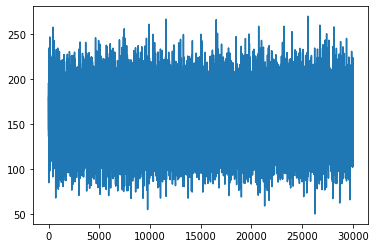

In [29]:
plt.plot(history.history['loss'])

In [30]:
res = model.predict([m1,m2,a],batch_size=n_dias)

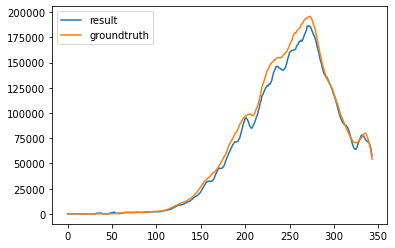

In [31]:
plt.plot(res[3:-3],label='result')
plt.plot(b[3:-3],label='groundtruth')
plt.legend()